In [38]:
import nltk
import os
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/vignesh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/vignesh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/vignesh/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [39]:
from pathlib import Path
ROOT_DIR=str(Path("__file__").absolute().parent.parent)
DATA_DIR=os.path.join(ROOT_DIR,"data")

In [40]:
import pandas as pd
import calendar
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [84]:
cdr = pd.read_csv(os.path.join(DATA_DIR,'raw/telco_cdr.tsv.gz'), compression='gzip', header=0, sep='\t', quotechar='"')
census = pd.read_csv(os.path.join(DATA_DIR,'raw/telco_census.tsv.gz'), compression='gzip', header=0, sep='\t', quotechar='"')
locations = pd.read_csv(os.path.join(DATA_DIR,'raw/telco_locations.tsv.gz'), compression='gzip', header=0, sep='\t', quotechar='"')
reviews = pd.read_csv(os.path.join(DATA_DIR,'raw/telco_reviews.tsv.gz'), compression='gzip', header=0, sep='\t', quotechar='"')
schools = pd.read_csv(os.path.join(DATA_DIR,'raw/telco_schools.tsv.gz'), compression='gzip', header=0, sep='\t', quotechar='"')
ddmr = pd.read_csv(os.path.join(DATA_DIR,'raw/telco_web.tsv.gz'), compression='gzip', header=0, sep='\t', quotechar='"')
train = pd.read_csv(os.path.join(DATA_DIR,'raw/telco_train.tsv.gz'), compression='gzip', header=0, sep='\t', quotechar='"')

## CDR aggregation

In [11]:
cdr['year'] = pd. DatetimeIndex(cdr['date']).year
cdr['month'] = pd. DatetimeIndex(cdr['date']).month
cdr['month_name'] = cdr['month'].apply(lambda x: calendar.month_abbr[x])
cdr_record_cols=[col for col in cdr.columns if col not in ['msisdn','date','year','month','month_name']]
cdr_per_month=cdr.groupby(['msisdn','year','month_name'])[cdr_record_cols].sum().reset_index()
cdr_per_month=cdr_per_month.pivot_table(index="msisdn", columns=["year","month_name"], values=cdr_record_cols).reset_index()

In [12]:
columns=['msisdn']+["%s_%s_%s"%(col[0],col[1],col[2]) for col in cdr_per_month.columns if col[1]!='']
cdr_per_month.columns=columns

### Preprocessing Reviews

In [15]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
 
def clean_text(text):
    text = text.lower()
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    text = [word for word in text if not any(c.isdigit() for c in word)]
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    text = [t for t in text if len(t) > 0]
    pos_tags = pos_tag(text)
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    text = [t for t in text if len(t) > 1]
    text = " ".join(text)
    return(text)

In [16]:
reviews["feedback_clean"] = reviews["feedback"].apply(lambda x: clean_text(x))
sid = SentimentIntensityAnalyzer()
reviews["sentiments"] = reviews["feedback"].apply(lambda x: sid.polarity_scores(x))
reviews = pd.concat([reviews.drop(['sentiments'], axis=1), reviews['sentiments'].apply(pd.Series)], axis=1)
reviews['comp_score'] = reviews['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

In [17]:
sentiment_scores=pd.get_dummies(reviews['comp_score'])
reviews_df=reviews.drop(['neg','neu','pos','compound'],axis=1)
reviews_df = reviews_df.join(sentiment_scores)

In [18]:
reviews_df.columns

Index(['msisdn', 'date', 'feedback', 'feedback_clean', 'comp_score', 'neg',
       'pos'],
      dtype='object')

In [19]:
count_vect = CountVectorizer()
feedback_vect = count_vect.fit_transform(reviews_df.feedback_clean)
feedback_vect_arr = feedback_vect.toarray()
review_vect = pd.DataFrame(data=feedback_vect_arr,columns = ["%s_%s"%(feat_nm,'word')for feat_nm in count_vect.get_feature_names()])

In [20]:
review_df=reviews_df.join(review_vect)

In [21]:
## aggregate monthly and yearly
review_df['year'] = pd.DatetimeIndex(review_df['date']).year
review_df['month'] = pd.DatetimeIndex(review_df['date']).month
review_df['month_name'] = review_df['month'].apply(lambda x: calendar.month_abbr[x])

In [22]:
review_df.drop(['date','feedback','feedback_clean'],axis=1,inplace=True)

In [23]:
review_sentiment_agg=review_df.groupby(['msisdn']).agg({'neg':sum,'pos':sum}).reset_index()

In [24]:
review_sent_score=review_df.groupby(['msisdn'])[list(review_vect.columns)+['neg','pos']].sum().reset_index()

In [60]:
review_vect.columns

Index(['aa_word', 'aaa_word', 'aaron_word', 'ab_word', 'abandon_word',
       'abandoned_word', 'abc_word', 'aberdeen_word', 'abilities_word',
       'ability_word',
       ...
       'zone_word', 'zones_word', 'zoning_word', 'zoo_word', 'zoom_word',
       'zope_word', 'zshops_word', 'zu_word', 'zum_word', 'zus_word'],
      dtype='object', length=9016)

In [25]:
review_sent_score=review_sentiment_agg.merge(review_sent_score,on=['msisdn'],how='inner')

NameError: name 'review_df_wrd_vct' is not defined

### DDMR AGGREDATION

In [26]:
## aggregate monthly and yearly
ddmr['year'] = pd. DatetimeIndex(ddmr['date']).year
ddmr['month'] = pd. DatetimeIndex(ddmr['date']).month
ddmr['month_name'] = ddmr['month'].apply(lambda x: calendar.month_abbr[x])
ddmr['website']=ddmr['website'].str.split(".").apply(lambda x : x[1])

In [27]:
ddmr.loc[ddmr["website"].str.contains("singtel|starhub"),'is_competitor']=True
ddmr.fillna(False,inplace=True)

In [28]:
ddmr_total_visits_per_month=ddmr.groupby(['msisdn','year','month_name']).agg(total_visits=('visits', 'sum')).reset_index()
ddmr_total_visits_per_year_per_website=ddmr.groupby(['msisdn','year','month_name','website']).agg(total_visits=('visits', 'sum')).reset_index()
ddmr_total_visits_per_year_per_competitor=ddmr[ddmr['is_competitor']==True].groupby(['msisdn','year','month_name','is_competitor']).agg(total_visits=('visits', 'sum')).reset_index()
ddmr_total_visits_per_year_per_others=ddmr[ddmr['is_competitor']==False].groupby(['msisdn','year','month_name','is_competitor']).agg(total_visits=('visits', 'sum')).reset_index()

In [29]:
ddmr_total_visits_per_year_per_competitor=ddmr_total_visits_per_year_per_competitor.pivot_table(index="msisdn", columns="month_name", values="total_visits").reset_index()
ddmr_total_visits_per_year_per_website=ddmr_total_visits_per_year_per_website.pivot_table(index="msisdn", columns=["month_name","website"], values="total_visits").reset_index()
ddmr_total_visits_per_month=ddmr_total_visits_per_month.pivot_table(index="msisdn", columns="month_name", values="total_visits").reset_index()
ddmr_total_visits_per_year_per_others=ddmr_total_visits_per_year_per_others.pivot_table(index="msisdn", columns="month_name", values="total_visits").reset_index()

In [30]:
new_columns=['msisdn']+["%s_%s"%(col[0],col[1]) for col in ddmr_total_visits_per_year_per_website.columns if col[1]!='']
ddmr_total_visits_per_year_per_website.columns=new_columns

In [31]:
competitor_new_cols=['msisdn']+["%s_competitor_visits"%(col.lower())for col in ddmr_total_visits_per_year_per_competitor.columns if col!='msisdn']
ddmr_total_visits_per_year_per_competitor.columns=competitor_new_cols

In [32]:
non_competitor_new_cols=['msisdn']+["%s_non_competitor_visits"%(col.lower()) for col in ddmr_total_visits_per_year_per_others.columns if col!='msisdn']
ddmr_total_visits_per_year_per_others.columns=non_competitor_new_cols

In [33]:
monthly_new_cols=['msisdn']+["%s_visits"%(col.lower())for col in ddmr_total_visits_per_month.columns if col!='msisdn']
ddmr_total_visits_per_month.columns=monthly_new_cols

In [34]:
ddmr_features=ddmr_total_visits_per_year_per_competitor.merge(ddmr_total_visits_per_year_per_website,on=['msisdn'],how="inner")\
.merge(ddmr_total_visits_per_year_per_others,on=['msisdn'],how="inner")\
.merge(ddmr_total_visits_per_month,on=['msisdn'],how="inner")

In [35]:
ddmr_features.shape

(15000, 49)

### Merging ddmr and training Feature

In [36]:
train_df=train.merge(ddmr_features,on=['msisdn'],how='left').\
merge(cdr_per_month,on=['msisdn'],how='left').\
merge(review_sent_score,on=['msisdn'],how='left')

In [37]:
import datetime

In [38]:
train_df=train_df.merge(census,on=['planning_area'],how='left')

In [39]:
def diff_month(start_date,end_date):
    print(type(start_date))
    return (start_date.year-end_date.year)*12+start_date.month-end_date.month

In [40]:
def last_day_of_month(yyyymm):
    day=datetime.datetime.strptime(str(yyyymm),"%Y-%m-%d")
    day=day.replace(day=calendar.monthrange(day.year,day.month)[1])
    return day

In [41]:
train_df['profile_month']=train_df['reference_date'].apply(lambda x : last_day_of_month(x))
train_df['account_start_date']=train_df['account_start_date'].apply(lambda x :  datetime.datetime.strptime(x,"%Y-%m-%d"))

In [42]:
train_df['customer_since']=train_df.apply(lambda x: diff_month(x['profile_month'],x['account_start_date']),axis=1)

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.tim

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.tim

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.tim

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.tim

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.tim

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.tim

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.tim

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.tim

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.tim

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.tim

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.tim

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.tim

In [175]:

train_df['cusomer_period_bin'] = pd.qcut(train_df['customer_since'],5)

customer_contract=train_df[train_df['churn']==0].groupby(['cusomer_period_bin'])[upload_columns].mean().reset_index()
customer_contract['total']=customer_contract.drop(['cusomer_period_bin'],axis=1).sum(axis=1)

In [216]:
top_10_feats=pd.read_csv('/Users/vignesh/confort_del/telco_churn/models/churn_log/models/XGB/feature_imp.txt')

In [217]:
top_10_feats.columns=['features','imp']

In [218]:
df=pd.read_parquet("/Users/vignesh/confort_del/telco_churn/models/churn_log/test_data_prediction_XGB.parquet")

In [219]:
df.columns

Index(['msisdn', 'age', 'dec_competitor_visits', 'feb_competitor_visits',
       'jan_competitor_visits', 'mar_competitor_visits',
       'nov_competitor_visits', 'oct_competitor_visits', 'Dec_cnn',
       'Dec_facebook', 'Dec_instagram', 'Dec_singtel', 'Dec_starhub',
       'Feb_cnn', 'Feb_facebook', 'Feb_instagram', 'Feb_singtel',
       'Feb_starhub', 'Jan_cnn', 'Jan_facebook', 'Jan_instagram',
       'Jan_singtel', 'Jan_starhub', 'Mar_cnn', 'Mar_facebook',
       'Mar_instagram', 'Mar_singtel', 'Mar_starhub', 'Nov_cnn',
       'Nov_facebook', 'Nov_instagram', 'Nov_singtel', 'Nov_starhub',
       'Oct_cnn', 'Oct_facebook', 'Oct_instagram', 'Oct_singtel',
       'Oct_starhub', 'data_download_2019_Dec', 'data_download_2019_Oct',
       'data_download_2020_Feb', 'data_upload_2019_Dec',
       'data_upload_2019_Nov', 'data_upload_2019_Oct', 'data_upload_2020_Feb',
       'sms_incoming_2019_Dec', 'sms_incoming_2019_Nov',
       'sms_incoming_2019_Oct', 'sms_incoming_2020_Feb',
       'sm

In [234]:
dfs=pd.DataFrame()
for feat in list(top_10_feats['features'].unique()):
    corr=df[[feat,'pred_proba']].corr().reset_index()['pred_proba'][0]
    df_tst=pd.DataFrame({'feature_name':[feat],"correlation":[corr]})
    dfs=pd.concat([dfs,df_tst])
print(dfs)

               feature_name  correlation
0  sgd_1000_to_1999_percent    -0.242493
0                       age    -0.451847
0    below_sgd_1000_percent    -0.099115
0            below_sgd_1000    -0.145901
0     feb_competitor_visits     0.196167
0     oct_competitor_visits     0.219152
0               Jan_singtel     0.258310
0     nov_competitor_visits     0.233164
0     jan_competitor_visits     0.322763
0     dec_competitor_visits     0.179240
0    data_download_2020_Feb     0.224023
0  sgd_2000_to_2999_percent    -0.266435
0               Dec_singtel     0.142951
0     mar_competitor_visits     0.221009
0            customer_since    -0.196964
0  sgd_3000_to_3999_percent    -0.149071
0               Mar_starhub     0.191157
0               Nov_starhub     0.157540
0               Nov_singtel     0.167452
0   voice_incoming_2019_Oct     0.006038


In [231]:
dfs.sort_values(by=['correlation'],ascending=False,inplace=True)

In [235]:
dfs=dfs.set_index('feature_name')

In [236]:
dfs

,correlation
feature_name,
sgd_1000_to_1999_percent,-0.242493
age,-0.451847
below_sgd_1000_percent,-0.099115
below_sgd_1000,-0.145901
feb_competitor_visits,0.196167
oct_competitor_visits,0.219152
Jan_singtel,0.258310
nov_competitor_visits,0.233164
jan_competitor_visits,0.322763


In [238]:
dfs['positive'] = dfs['correlation'] > 0

<AxesSubplot:ylabel='feature_name'>

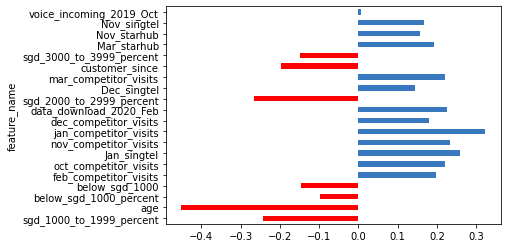

In [244]:
dfs['correlation'].plot(kind='barh',color=dfs.positive.map({True: '#3778bf', False: 'r'}))

In [242]:
dfs

,correlation,positive
feature_name,,
sgd_1000_to_1999_percent,-0.242493,False
age,-0.451847,False
below_sgd_1000_percent,-0.099115,False
below_sgd_1000,-0.145901,False
feb_competitor_visits,0.196167,True
oct_competitor_visits,0.219152,True
Jan_singtel,0.258310,True
nov_competitor_visits,0.233164,True
jan_competitor_visits,0.322763,True


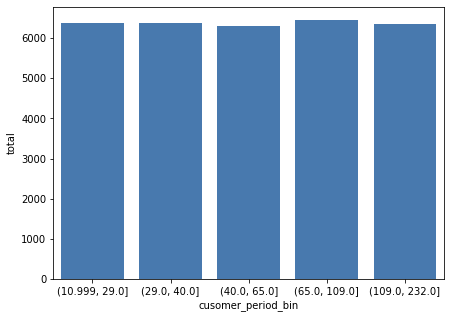

In [176]:

import matplotlib.pyplot as plt
import seaborn as sns
 
fig,ax=plt.subplots(figsize=(7,5))
sns.barplot(x = "cusomer_period_bin", y = "total", data = customer_contract[['cusomer_period_bin','total']],color='#3778bf',dodge=False)
plt.show()

# train_df[upload_columns].mean()

In [53]:
upload_columns=[]
for col in train_df.columns:
    if "data_upload" in col:
        upload_columns.append(col)

In [ ]:
train_df.drop(['name','reference_date','planning_area','account_start_date','address','latlong','birthday'],axis=1,inplace=True)

In [83]:
pd.get_dummies(train,columns=['gender','contract','internet_service'])

,msisdn,churn,name,age,birthday,account_start_date,address,latlong,planning_area,reference_date,gender_female,gender_male,contract_monthly,contract_two-year,internet_service_fiber,internet_service_no
0,6048764759382,False,Samuel Stephens,44,1977-04-18,2018-03-15,94 LOR 4 TOA PAYOH,"1.33889442783828,103.849538318068",TOA PAYOH,2020-04-15,0,1,1,0,1,0
1,1948924115781,False,Dana Alexander,21,1999-08-19,2016-07-14,109 ALJUNIED CRES,"1.31939291785824,103.884439876207",GEYLANG,2020-04-15,1,0,0,1,1,0
2,5938778408016,False,Megan Rose,57,1963-09-13,2018-11-24,208 BOON LAY PL,"1.3465747534549,103.714427056113",JURONG WEST,2020-04-15,1,0,1,0,1,0
3,975351393328,False,Bianca Norman,49,1971-11-29,2014-04-03,548 BEDOK NTH AVE 1,"1.33131021834566,103.92685391703",BEDOK,2020-04-15,1,0,0,1,0,1
4,1587148418583,False,Pamela Romero,24,1996-05-27,2011-10-31,45 CHAI CHEE ST,"1.32864779394512,103.924495382454",BEDOK,2020-04-15,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,197681231203,False,Erica Cooke,59,1961-07-15,2009-11-16,231 JURONG EAST ST 21,"1.34112749546642,103.738101187795",JURONG EAST,2020-04-15,1,0,1,0,0,1
14996,6183326134523,False,Debbie Hunter,39,1981-07-18,2018-04-14,8 EMPRESS RD,"1.31641190098177,103.805373811937",BUKIT TIMAH,2020-04-15,1,0,1,0,1,0
14997,9770826000249,False,Abigail Berger,31,1989-09-01,2011-07-13,98 WHAMPOA DR,"1.32158068709131,103.854150953187",NOVENA,2020-04-15,1,0,0,1,1,0
14998,5855470225901,False,Christina Bailey,35,1986-03-21,2018-09-18,147 SERANGOON NTH AVE 1,"1.36847950992105,103.872662860362",SERANGOON,2020-04-15,1,0,0,1,0,1


In [357]:
gender_df=pd.get_dummies(train_df['gender'])
contract_status_df=pd.get_dummies(train_df['contract'])
service_type_df=pd.get_dummies(train_df['internet_service'])

In [ ]:
pd.get_dummies(train_df['gender'])

In [360]:
service_type_df.columns=['fibre','non_fibre']

In [364]:
train_df=train_df.join(gender_df).join(contract_status_df).join(service_type_df)

In [384]:
train_df.drop(['gender','contract','internet_service','profile_month'],axis=1,inplace=True,errors='ignore')

In [379]:
train_df['churn_label']=train_df['churn'].apply(lambda x: 1 if x==True else 0)
train_df.drop(['churn'],axis=1,inplace=True)

In [388]:
train_df.groupby('churn_label')['churn_label'].count()

churn_label
0    13442
1     1558
Name: churn_label, dtype: int64